<a href="https://colab.research.google.com/github/raminass/scotus/blob/main/train_model_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [1]:
!pip install datasets evaluate transformers accelerate eyecite --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 8.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/projects/us_supreme_court

/content/drive/MyDrive/projects/us_supreme_court


In [4]:
from utils.pre_train import *
from utils.notebook_utils import *

%load_ext autoreload
%autoreload 2

# Read Data

## 2020-2023

In [ ]:
opinions_20_23 = pd.read_excel('data/2020-2023.xlsx')
opinions_20_23 = opinions_20_23[['Text', 'Opinion', 'Judge', 'Case']]
opinions_20_23.fillna(method='ffill', inplace=True)
opinions_20_23 = opinions_20_23.groupby(['Opinion', 'Judge', 'Case'])['Text'].apply(lambda x: ' '.join(x)).reset_index()
opinions_20_23.rename(columns={'Text': 'text', 'Opinion':'type', 'Judge':'author', 'Case':'case_name'}, inplace=True)

In [ ]:
opinions_20_23['author'] = opinions_20_23['author'].replace(['Kavanaugh ',"Barret","S", "PER CURIAM"],[ 'Kavanaugh', "Barrett", "Sotomayor","per_curiam"])
opinions_20_23['type'] = opinions_20_23['type'].replace(['Majority',"Concur","Dissent", "PER CURIAM"],[ 'majority', "concurring", "dissenting","per_curiam"])
opinions_20_23['author'] = opinions_20_23['author'].replace(['Gorsuch '], ['Gorsuch'])
opinions_20_23 = opinions_20_23[opinions_20_23.author!='Ginsburg']

In [ ]:
opinions_20_23.author.unique()

array(['Alito', 'Barrett', 'Breyer', 'Gorsuch', 'Jackson', 'Kagan',
       'Kavanaugh', 'Roberts', 'Sotomayor', 'Thomas', 'per_curiam'],
      dtype=object)

In [ ]:
opinions_20_23.shape

(438, 4)

In [ ]:
opinions_20_23.sample(5)

,type,author,case_name,text
335,majority,Kagan,"Lange v. California, 20-18",The Fourth Amendment ordinarily requires that ...
348,majority,Kavanaugh,"Greer v. United States, 19-8709",Federal law prohibits the possession of firear...
229,dissenting,Thomas,"Haaland v. Brackeen, 21-376",These cases concern the Federal Government’s a...
138,dissenting,Alito,"California v. Texas, 19-840",Today’s decision is the third installment in o...
204,dissenting,Kavanaugh,"Borden v. United States, 19-5410","As an initial matter,\nMusacchio did not addre..."


In [ ]:
opinions_20_23.author.value_counts()

Thomas        72
Gorsuch       62
Sotomayor     51
Alito         47
Kavanaugh     45
Barrett       36
Kagan         35
Roberts       29
Breyer        27
Jackson       18
per_curiam    16
Name: author, dtype: int64

In [ ]:
opinions_20_23.type.value_counts()

majority      174
concurring    137
dissenting    111
per_curiam     16
Name: type, dtype: int64

## 1994-2020

In [ ]:
# filter dates and Judges
opinions_since_1970 = pd.read_csv('data/opinions_since_1970.csv')
opinions_1994_2020 = opinions_since_1970[(opinions_since_1970['date_filed'] > "1994-09-01")].copy()
opinions_1994_2020['author_name'] = opinions_1994_2020['author_name'].replace(['Justice O2122','Justice Connor'],["Justice O'Connor", "Justice O'Connor"])

# j_list = ['Justice Roberts', 'Justice Thomas', 'Justice Breyer',
#        'Justice Kagan', 'Justice Scalia', 'Justice Kennedy', 'per_curiam',
#        'Justice Ginsburg', 'Justice Alito',
#        'Justice Stevens', 'Justice Rehnquist',
#        'Justice Souter', "Justice O'Connor", 'Justice Sotomayor']

old_j = ["Justice White", "Justice Holmes", "Justice Woods", "Justice Waite", "Justice Fuller", "Justice McReynolds"]
opinions_1994_2020 = opinions_1994_2020[~opinions_1994_2020['author_name'].isin(old_j)]
opinions_1994_2020 = opinions_1994_2020[['author_name', 'category', 'case_name', 'text']]
opinions_1994_2020.rename(columns={'category':'type', 'author_name':'author'}, inplace=True)
opinions_1994_2020['author'] = opinions_1994_2020['author'].replace(['Justice Thomas','Justice Scalia', 'Justice Breyer', 'Justice Stevens','Justice Ginsburg', 'Justice Kennedy', 'Justice Alito', 'Justice Souter', 'Justice Sotomayor', "Justice O'Connor", "Justice Rehnquist", "Justice Kagan", "Justice Roberts", "Justice Kavanaugh", "Justice Gorsuch"],
                                                          ["Thomas", "Scalia", "Breyer", "Stevens", "Ginsburg", "Kennedy", "Alito", "Souter", "Sotomayor", "O'Connor", "Rehnquist", "Kagan", "Roberts", "Kavanaugh", "Gorsuch"])


In [ ]:
opinions_1994_2020.author.value_counts()

Thomas        499
Scalia        473
Breyer        416
Stevens       407
Ginsburg      390
Kennedy       326
Alito         239
Souter        230
Sotomayor     175
O'Connor      167
Rehnquist     144
per_curiam    120
Kagan         110
Roberts        94
Gorsuch        47
Kavanaugh      20
Name: author, dtype: int64

In [ ]:
opinions_1994_2020.type.value_counts()

majority             1810
dissenting            967
concurring            711
second_dissenting     249
per_curiam            120
Name: type, dtype: int64

In [ ]:
opinions_1994_2020 = opinions_1994_2020[opinions_1994_2020.type=='majority']

In [ ]:
opinions_1994_2020.sample(5)

,author,type,case_name,text
2500,Scalia,majority,Brown v. Sanders,We consider the circumstances in which an inva...
3280,Kennedy,majority,Lozman v. Riviera Beach,This case requires the Court to address the in...
1803,Rehnquist,majority,Florida v. Thomas,"In New York v. Belton, 453 U.S. 454 (1981), we..."
3950,Thomas,majority,Mont v. United States,This case requires the Court to decide whether...
2866,Ginsburg,majority,Florida v. Nixon,This capital case concerns defense counsel's s...


In [ ]:
opinions = pd.concat([opinions_20_23, opinions_1994_2020], ignore_index=True)

In [ ]:
opinions.shape

(4295, 4)

In [ ]:
opinions = opinions[opinions.author!='per_curiam']

In [ ]:
opinions.author.value_counts()

Thomas       571
Scalia       473
Breyer       443
Stevens      407
Ginsburg     390
Kennedy      326
Alito        286
Souter       230
Sotomayor    226
O'Connor     167
Kagan        145
Rehnquist    144
Roberts      123
Gorsuch      109
Kavanaugh     65
Barrett       36
Jackson       18
Name: author, dtype: int64

In [ ]:
opinions.author.unique()

array(['Alito', 'Barrett', 'Breyer', 'Gorsuch', 'Jackson', 'Kagan',
       'Kavanaugh', 'Roberts', 'Sotomayor', 'Thomas', 'Kennedy',
       'Ginsburg', 'Scalia', 'Stevens', 'Rehnquist', 'Souter', "O'Connor"],
      dtype=object)

In [ ]:
opinions.shape

(4159, 4)

# Cleaning the Citations

In [ ]:
opinions = opinions[~opinions.author.isin(['Jackson', 'Barrett'])]

In [ ]:
opinions.author.value_counts()

Thomas       571
Scalia       473
Breyer       443
Stevens      407
Ginsburg     390
Kennedy      326
Alito        286
Souter       230
Sotomayor    226
O'Connor     167
Kagan        145
Rehnquist    144
Roberts      123
Gorsuch      109
Kavanaugh     65
Name: author, dtype: int64

In [ ]:
opinions.type.value_counts()

majority             1960
dissenting           1063
concurring            833
second_dissenting     249
Name: type, dtype: int64

In [ ]:
opinions['clean_text'] = opinions.apply(lambda x: remove_citations(x['text']), axis=1)

In [ ]:
opinions["clean_text"] = opinions.apply(
    lambda x: x.clean_text.split("It is so ordered.")[0]
    if x.type == "majority"
    else x.clean_text,
    axis=1,
)

In [ ]:
import os
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
opinions['type'] = opinions['type'].replace(['second_dissenting'],['dissenting'])

In [ ]:
opinions.type.value_counts()

majority      1960
dissenting    1312
concurring     833
Name: type, dtype: int64

In [ ]:
opinions.author.value_counts()

Thomas       571
Scalia       473
Breyer       443
Stevens      407
Ginsburg     390
Kennedy      326
Alito        286
Souter       230
Sotomayor    226
O'Connor     167
Kagan        145
Rehnquist    144
Roberts      123
Gorsuch      109
Kavanaugh     65
Name: author, dtype: int64

In [ ]:
opinions_ds = Dataset.from_pandas(opinions, preserve_index=False)
opinions_ds.push_to_hub("raminass/opinions-94-23")

In [9]:
opinions=opinions[opinions.author!='per_curiam']

In [10]:
opinions.type.value_counts()

majority      1953
dissenting    1320
concurring     821
Name: type, dtype: int64

In [ ]:
id2label, label2id = get_labels_maping(opinions)

In [ ]:
opinions["label"] = opinions["author"].map(label2id)

In [ ]:
opinions.sample(3)

,type,author,case_name,text,clean_text,label
3656,majority,Souter,United States v. Noland,The issue in this case is the scope of a bankr...,The issue in this case is the scope of a bankr...,13
1515,concurring,Souter,Munaf v. Geren,"The Court holds that ""[u]nder circumstances su...","The Court holds that ""[u]nder circumstances su...",13
304,majority,Kavanaugh,"United States v. Vaello Madero, 20-303",The United States includes five Territories: A...,The United States includes five Territories: A...,4


# Train-Test

In [ ]:
all = load_dataset("raminass/opinions-94-23")
opinions = pd.DataFrame(all["train"])

In [17]:
opinions = opinions[~opinions.author.isin(['Kavanaugh', 'Barrett', 'Jackson'])]

In [18]:
opinions=opinions[opinions.author!='per_curiam']

In [19]:
opinions.shape

(4040, 5)

In [20]:
opinions.type.value_counts()

majority      1929
dissenting    1305
concurring     806
Name: type, dtype: int64

In [15]:
opinions.author.value_counts()

Thomas       571
Scalia       473
Breyer       443
Stevens      407
Ginsburg     390
Kennedy      326
Alito        286
Souter       230
Sotomayor    226
O'Connor     167
Kagan        145
Rehnquist    144
Roberts      123
Gorsuch      109
Barrett       36
Jackson       18
Name: author, dtype: int64

In [ ]:
id2label, label2id = get_labels_maping(opinions)
opinions["label"] = opinions["author"].map(label2id)

In [ ]:
from sklearn.model_selection import train_test_split

opinions_train, opinions_test = train_test_split(opinions, random_state=1984, test_size=0.2, stratify=opinions['label'])

In [ ]:
opinions_test.author.value_counts()

Thomas       114
Scalia        95
Breyer        89
Stevens       81
Ginsburg      78
Kennedy       65
Alito         57
Souter        46
Sotomayor     45
O'Connor      33
Kagan         29
Rehnquist     29
Roberts       25
Gorsuch       22
Name: author, dtype: int64

In [ ]:
opinions_train.author.value_counts()

Thomas       457
Scalia       378
Breyer       354
Stevens      326
Ginsburg     312
Kennedy      261
Alito        229
Souter       184
Sotomayor    181
O'Connor     134
Kagan        116
Rehnquist    115
Roberts       98
Gorsuch       87
Name: author, dtype: int64

# Split Paragraphs

In [ ]:
par_train = split_data(opinions_train, id2label, label2id)
par_test = split_data(opinions_test, id2label, label2id)

In [ ]:
par_train.author.value_counts()

Thomas       3650
Breyer       3075
Scalia       2922
Kennedy      2741
Alito        2521
Ginsburg     2438
Stevens      2134
Sotomayor    1855
Souter       1528
Kagan        1403
O'Connor     1190
Roberts      1058
Gorsuch       936
Rehnquist     729
Name: author, dtype: int64

In [ ]:
par_test.author.value_counts()

Breyer       858
Thomas       849
Alito        772
Scalia       745
Ginsburg     740
Kennedy      704
Sotomayor    464
Stevens      441
Souter       423
Kagan        349
O'Connor     274
Roberts      262
Gorsuch      258
Rehnquist    200
Name: author, dtype: int64

In [ ]:
# par_train = par_train.groupby('author',as_index = False,group_keys=False).apply(lambda s: s.sample(2000, replace=len(s)<2000))

In [ ]:
par_train.author.value_counts()

In [ ]:
# par_test = par_test.groupby('author',as_index = False,group_keys=False).apply(lambda s: s.sample(400, replace=len(s)<400))

In [ ]:
par_test.author.value_counts()

# Model

In [ ]:
from utils import train

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds_dict = {
        "train": Dataset.from_pandas(
            par_train[["label", "text"]], preserve_index=False
        ),
        "test": Dataset.from_pandas(
            par_test[["label", "text"]], preserve_index=False
        ),
    }
ds = DatasetDict(ds_dict)
tokenized_court = train.tokenize_dataset(ds)

Map:   0%|          | 0/28180 [00:00<?, ? examples/s]

Map:   0%|          | 0/7339 [00:00<?, ? examples/s]

In [ ]:
 trainer = train.get_trainer(
        id2label,
        label2id,
        tokenized_court,
        epochs=5,
        model_name=f"SCOTUS_AI_v2",
        batch_size=16,
        push_to_hub=True,
    )
trainer.train()

In [ ]:
trainer.push_to_hub(;)

CommitInfo(commit_url='https://huggingface.co/raminass/SCOTUS_AI_v2/commit/104d8cefb917dff0a04b9704f18dba5face64265', commit_message='End of training', commit_description='', oid='104d8cefb917dff0a04b9704f18dba5face64265', pr_url=None, pr_revision=None, pr_num=None)

# Analysis

In [ ]:
from scipy.special import softmax
pred = []
for index, row in opinions_test.iterrows():
  chunks = split_text(row["clean_text"])
  list_ds = [{"text":c} for c in chunks]
  tokenized_case = train.tokenize_dataset(Dataset.from_list(list_ds))
  predictions = trainer.predict(tokenized_case)
  avg = softmax(predictions.predictions, axis=1).mean(axis=0)
  pred.append(np.argmax(avg))

In [ ]:
(pred == opinions_test['label']).mean()

0.9183168316831684

In [ ]:
from utils import metrics

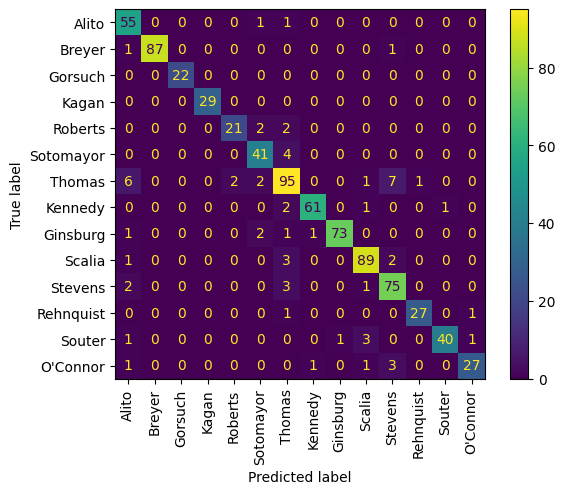

In [ ]:
metrics.plot_confusion(opinions_test['label'],pred, label2id)

In [ ]:
metrics.print_metrics(opinions_test['author'],[id2label[i] for i in pred])


-------------------- Key Metrics --------------------

Accuracy: 0.92
Balanced Accuracy: 0.92

Micro Precision: 0.92
Micro Recall: 0.92
Micro F1-score: 0.92

Macro Precision: 0.93
Macro Recall: 0.92
Macro F1-score: 0.92

Weighted Precision: 0.92
Weighted Recall: 0.92
Weighted F1-score: 0.92

--------------- Classification Report ---------------

              precision    recall  f1-score   support

       Alito       0.81      0.96      0.88        57
      Breyer       1.00      0.98      0.99        89
    Ginsburg       0.99      0.94      0.96        78
     Gorsuch       1.00      1.00      1.00        22
       Kagan       1.00      1.00      1.00        29
     Kennedy       0.97      0.94      0.95        65
    O'Connor       0.93      0.82      0.87        33
   Rehnquist       0.96      0.93      0.95        29
     Roberts       0.91      0.84      0.87        25
      Scalia       0.93      0.94      0.93        95
   Sotomayor       0.85      0.91      0.88        45
  

In [ ]:
list_test = [{"text":c} for c in par_test.text]
tokenized_case = train.tokenize_dataset(Dataset.from_list(list_test))
par_model_pred = trainer.predict(tokenized_case)
l = par_model_pred.predictions.argmax(axis=1)

Map:   0%|          | 0/7339 [00:00<?, ? examples/s]

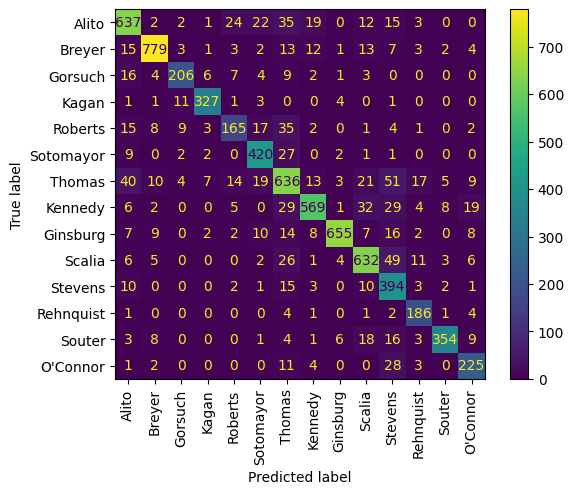

In [ ]:
metrics.plot_confusion(par_test['label'],l, label2id)

In [ ]:
metrics.print_metrics(par_test['author'],[id2label[i] for i in l])


-------------------- Key Metrics --------------------

Accuracy: 0.84
Balanced Accuracy: 0.84

Micro Precision: 0.84
Micro Recall: 0.84
Micro F1-score: 0.84

Macro Precision: 0.84
Macro Recall: 0.84
Macro F1-score: 0.84

Weighted Precision: 0.85
Weighted Recall: 0.84
Weighted F1-score: 0.84

--------------- Classification Report ---------------

              precision    recall  f1-score   support

       Alito       0.83      0.83      0.83       772
      Breyer       0.94      0.91      0.92       858
    Ginsburg       0.97      0.89      0.92       740
     Gorsuch       0.87      0.80      0.83       258
       Kagan       0.94      0.94      0.94       349
     Kennedy       0.90      0.81      0.85       704
    O'Connor       0.78      0.82      0.80       274
   Rehnquist       0.79      0.93      0.85       200
     Roberts       0.74      0.63      0.68       262
      Scalia       0.84      0.85      0.84       745
   Sotomayor       0.84      0.91      0.87       464
  

# Evaluation

In [ ]:
from utils import post_train

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model = post_train.load_model_from_hub('raminass/SCOTUS_AI_v2', 14)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/140M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/702k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
post_train.predict_labels(split_text(opinions_test.iloc[2,:]["clean_text"]), model)

[1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 10]

In [ ]:
opinions_test.sample(4)

,type,author,case_name,text,clean_text,label
4071,dissenting,Stevens,Ewing v. California,JUSTICE BREYER has cogently explained why the ...,JUSTICE BREYER has cogently explained why the ...,10
2482,concurring,Kennedy,Clinton v. City of New York,A Nation cannot plunder its own treasury witho...,A Nation cannot plunder its own treasury witho...,7
981,dissenting,Sotomayor,Davis v. Ayala,"At Hector Ayala’s trial, the prosecution exerc...","At Hector Ayala’s trial, the prosecution exerc...",5
2265,majority,Sotomayor,"Husky Int'l Electronics, Inc. v. Ritz",The Bankruptcy Code prohibits debtors from dis...,The Bankruptcy Code prohibits debtors from dis...,5
